In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests

In [4]:
fulldf=pd.read_csv('cleanedFulldf.csv', index_col=0)

In [37]:
regdf = fulldf.copy()

In [40]:
# drop NAs (games where there are no good deals)
print "Removed:", np.sum(np.isnan(regdf.lowest_price_good)), "rows"
regdf = regdf.loc[np.isnan(regdf['lowest_price_good']) == 0]

Removed: 4 rows


# Examine Plots to Determine if Transformations are Needed

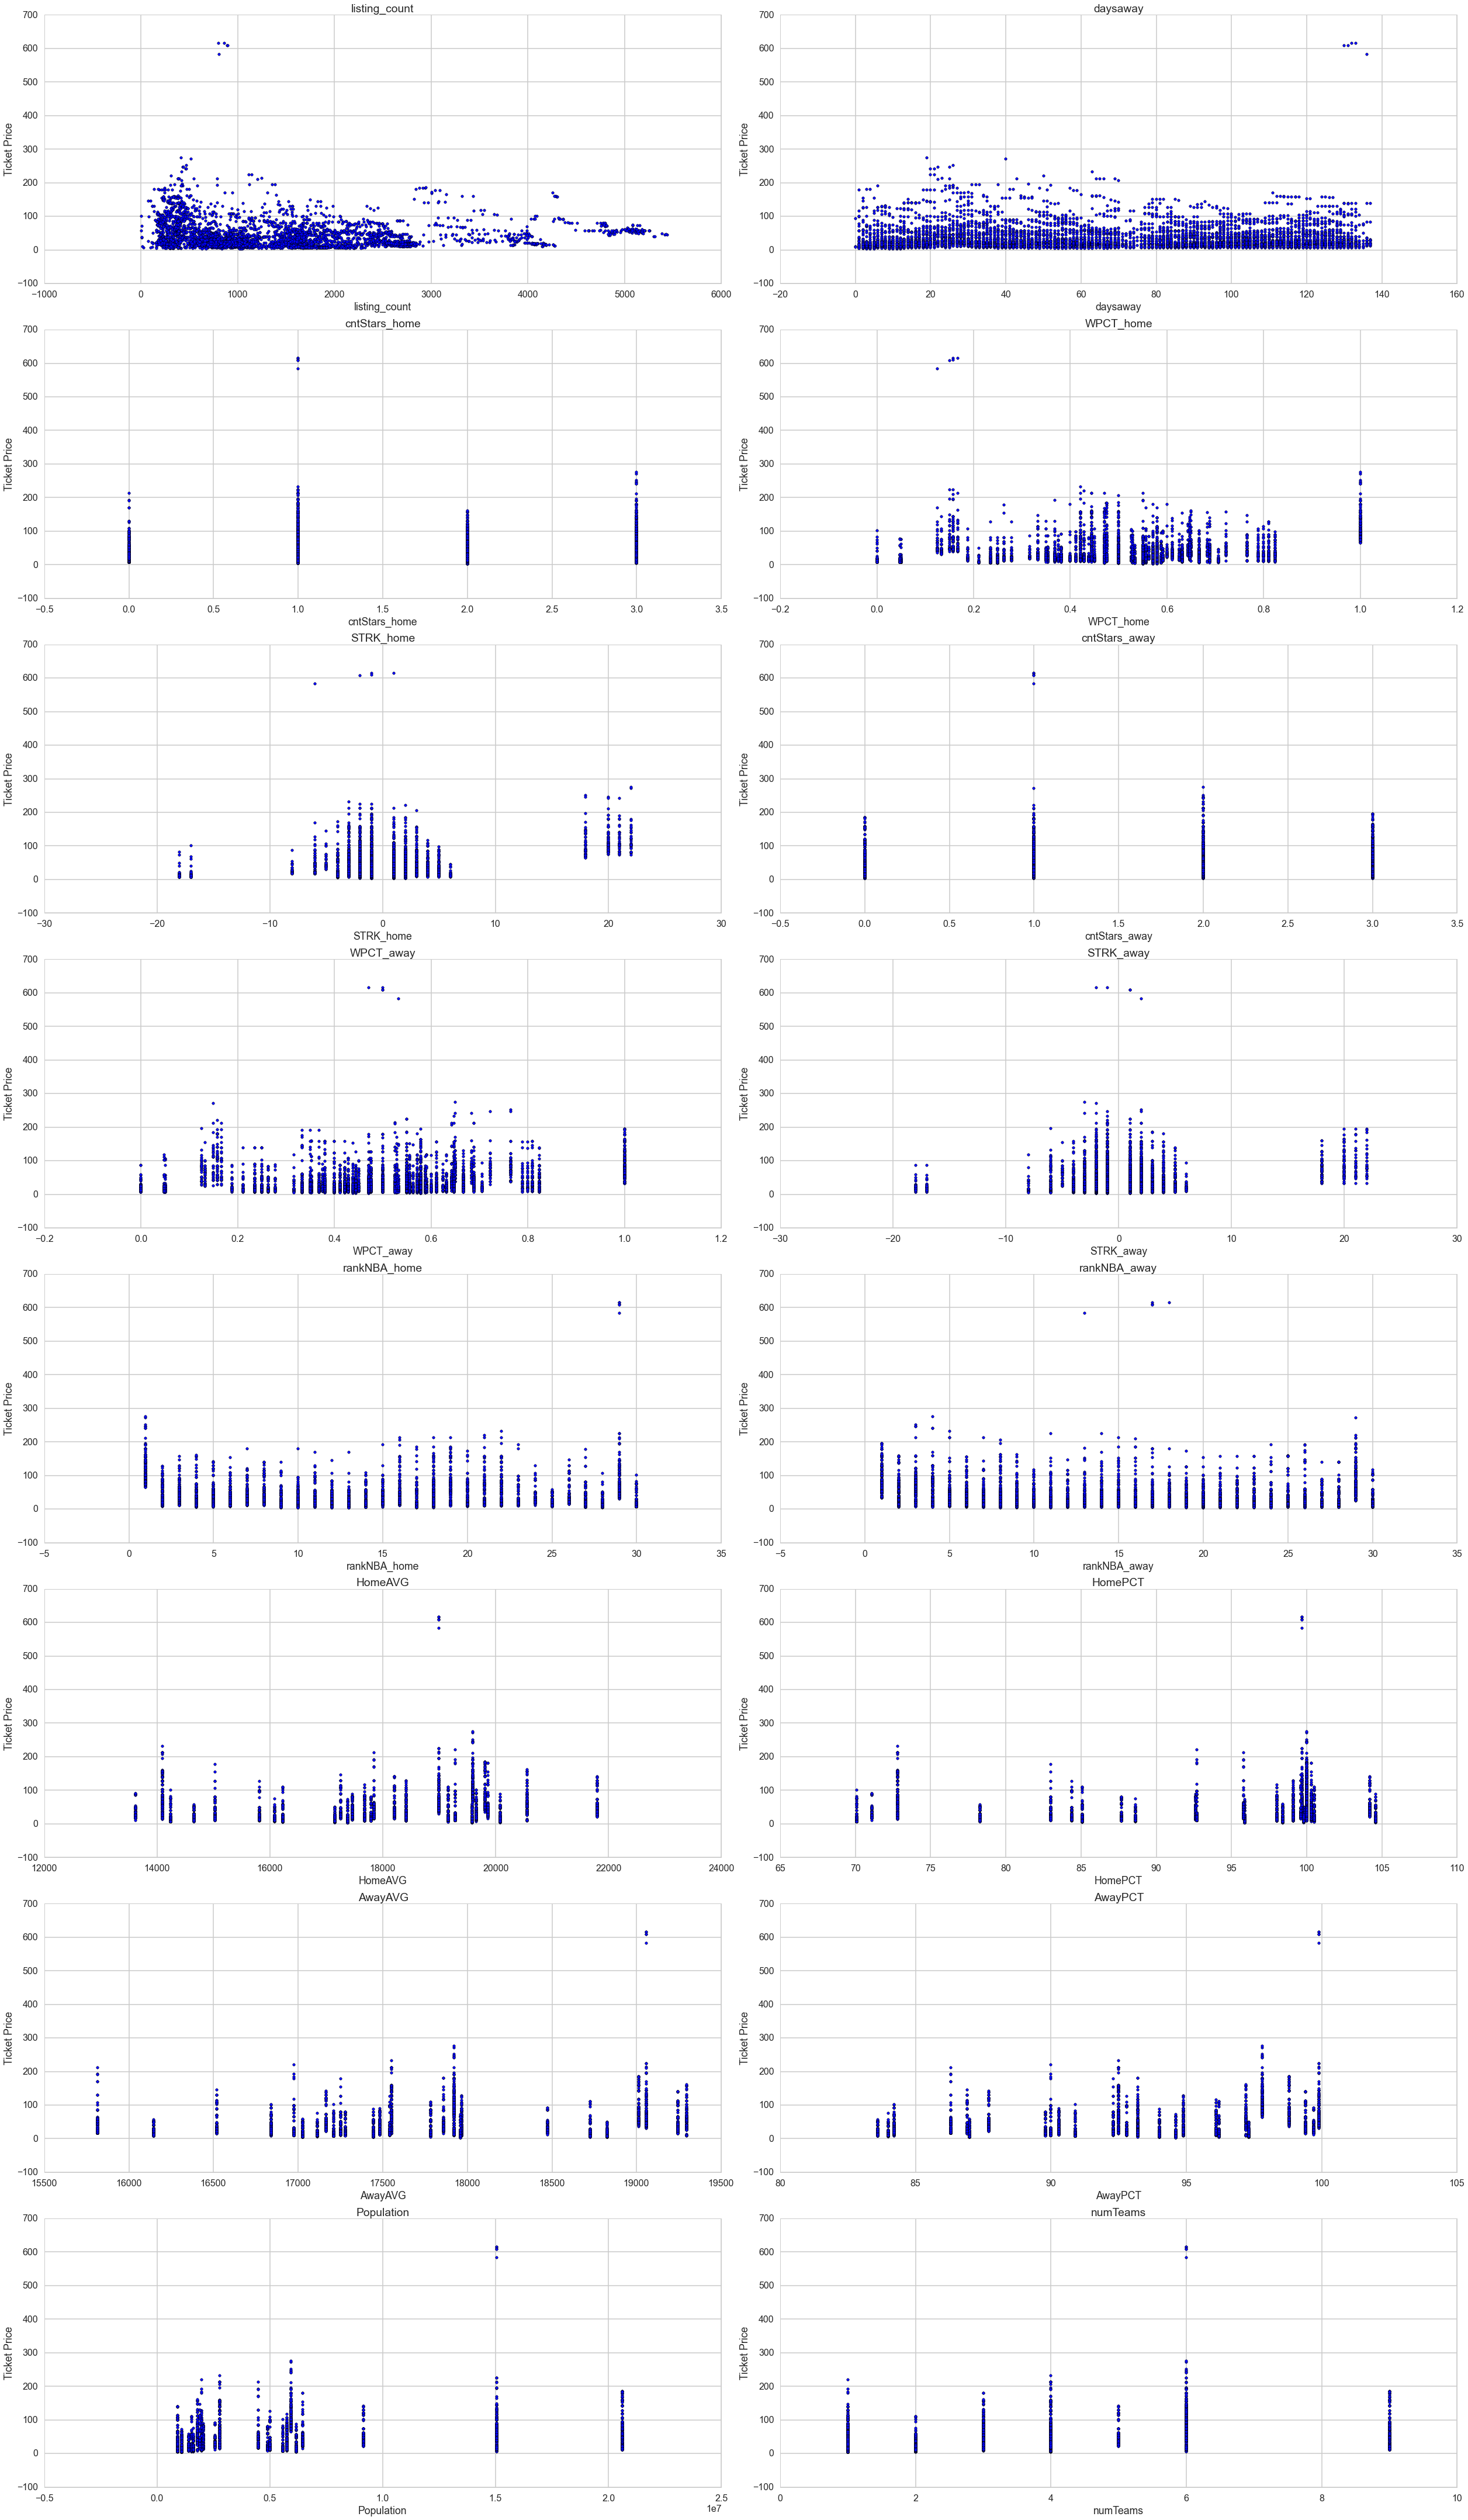

In [41]:
# examine the more continuous variables for transformations
continuousvariables = ['listing_count',
 'daysaway',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',
 'cntStars_away',
 'WPCT_away',
 'STRK_away',
 'rankNBA_home',
 'rankNBA_away',
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday']


fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(35, 60), tight_layout=True)
for ax, xvar in zip(axes.ravel(), continuousvariables):
    ax.scatter(regdf[xvar], regdf["lowest_price_good"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

They also seem to have a polynomial relationship, so we allow for x^2.

In [42]:
regdf["STRK_away_cubed"] = regdf["STRK_away"] ** 3
regdf["STRK_home_cubed"] = regdf["STRK_home"] ** 3

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


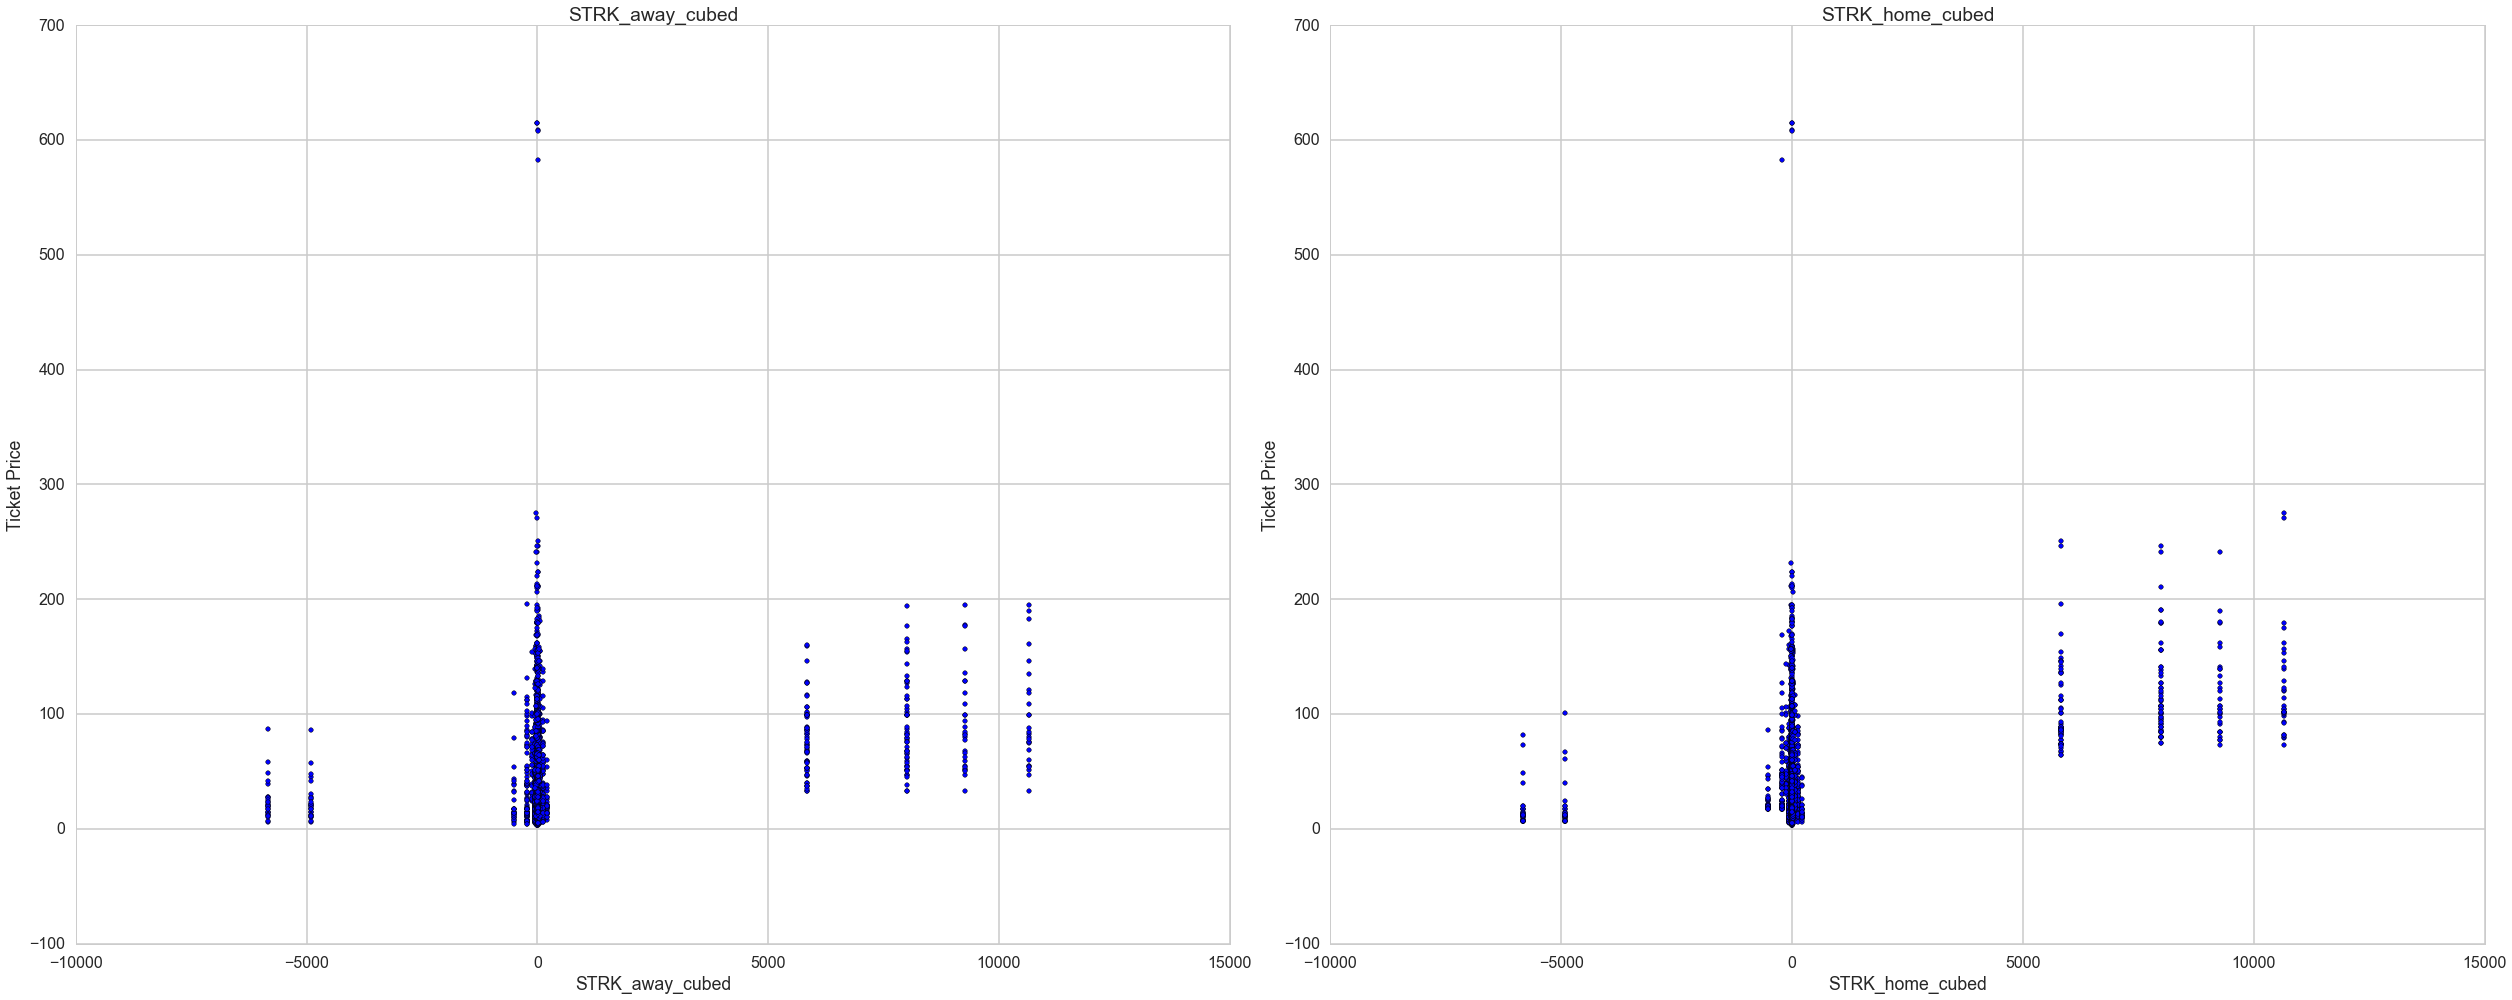

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 14), tight_layout=True)
for ax, xvar in zip(axes.ravel(), ["STRK_away_cubed", "STRK_home_cubed"]):
    ax.scatter(regdf[xvar], regdf["lowest_price_good"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

In [44]:
# define the sets of variables for 3 models of different layers of complexity
xvarssimple = ['listing_count',
 'venuename',
 'daysaway',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',            
 'STRK_home_cubed',                        
 'cntStars_away',
 'WPCT_away',
 'STRK_away',            
 'STRK_away_cubed',                        
 'rankNBA_home',
 'rankNBA_away',            
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday',
 'weekday']

In [45]:
xvarsintuitive = xvarssimple + [
 'holiday:HomePCT',
 'holiday:AwayPCT',
 'holiday:daysaway',
 'daysaway_oneover'
  ]

In [46]:
regdf['daysaway_oneover'] = 1/regdf['daysaway']

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
# make additional interaction terms
listVar=['listing_count',
 'daysaway',
 'cntStars_home',
 'WPCT_home',                     
 'cntStars_away',
 'WPCT_away',                            
 'rankNBA_home',
 'rankNBA_away',            
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday']
listInteract=[]
for num in range(len(listVar)):
    for num1 in range(num,len(listVar)):
        if num != num1:
            name = listVar[num]+':'+listVar[num1]
            if name not in xvarsintuitive:
                listInteract.append(name)

In [48]:
xvarsall = xvarsintuitive + listInteract
#['holiday', 'holiday:HomePCT', 'holiday:AwayPCT', 'holiday:daysaway','daysaway_sq', 'STRK_home_cubed', 'STRK_away_cubed','listing_count','daysaway','numTeams','Population','rankNBA_home','rankNBA_away','WPCT_home','WPCT_away','cntStars_home','cntStars_away','STRK_home','STRK_away','HomePCT','AwayPCT','listing_count:listing_count','listing_count:daysaway','listing_count:numTeams','listing_count:Population','listing_count:rankNBA_home','listing_count:rankNBA_away','listing_count:WPCT_home','listing_count:WPCT_away','listing_count:cntStars_home','listing_count:cntStars_away','listing_count:STRK_home','listing_count:STRK_away','listing_count:HomePCT','listing_count:AwayPCT','daysaway:daysaway','daysaway:numTeams','daysaway:Population','daysaway:rankNBA_home','daysaway:rankNBA_away','daysaway:WPCT_home','daysaway:WPCT_away','daysaway:cntStars_home','daysaway:cntStars_away','daysaway:STRK_home','daysaway:STRK_away','daysaway:HomePCT','daysaway:AwayPCT','numTeams:numTeams','numTeams:Population','numTeams:rankNBA_home','numTeams:rankNBA_away','numTeams:WPCT_home','numTeams:WPCT_away','numTeams:cntStars_home','numTeams:cntStars_away','numTeams:STRK_home','numTeams:STRK_away','numTeams:HomePCT','numTeams:AwayPCT','Population:Population','Population:rankNBA_home','Population:rankNBA_away','Population:WPCT_home','Population:WPCT_away','Population:cntStars_home','Population:cntStars_away','Population:STRK_home','Population:STRK_away','Population:HomePCT','Population:AwayPCT','rankNBA_home:rankNBA_home','rankNBA_home:rankNBA_away','rankNBA_home:WPCT_home','rankNBA_home:WPCT_away','rankNBA_home:cntStars_home','rankNBA_home:cntStars_away','rankNBA_home:STRK_home','rankNBA_home:STRK_away','rankNBA_home:HomePCT','rankNBA_home:AwayPCT','rankNBA_away:rankNBA_away','rankNBA_away:WPCT_home','rankNBA_away:WPCT_away','rankNBA_away:cntStars_home','rankNBA_away:cntStars_away','rankNBA_away:STRK_home','rankNBA_away:STRK_away','rankNBA_away:HomePCT','rankNBA_away:AwayPCT','WPCT_home:WPCT_home','WPCT_home:WPCT_away','WPCT_home:cntStars_home','WPCT_home:cntStars_away','WPCT_home:STRK_home','WPCT_home:STRK_away','WPCT_home:HomePCT','WPCT_home:AwayPCT','WPCT_away:WPCT_away','WPCT_away:cntStars_home','WPCT_away:cntStars_away','WPCT_away:STRK_home','WPCT_away:STRK_away','WPCT_away:HomePCT','WPCT_away:AwayPCT','cntStars_home:cntStars_home','cntStars_home:cntStars_away','cntStars_home:STRK_home','cntStars_home:STRK_away','cntStars_home:HomePCT','cntStars_home:AwayPCT','cntStars_away:cntStars_away','cntStars_away:STRK_home','cntStars_away:STRK_away','cntStars_away:HomePCT','cntStars_away:AwayPCT','STRK_home:STRK_home','STRK_home:STRK_away','STRK_home:HomePCT','STRK_home:AwayPCT','STRK_away:STRK_away','STRK_away:HomePCT','STRK_away:AwayPCT','HomePCT:HomePCT','HomePCT:AwayPCT','AwayPCT:AwayPCT']

In [63]:
venues

array(['AT&T Center', 'Air Canada Centre', 'American Airlines Arena',
       'American Airlines Center', 'Amway Center',
       'BMO Harris Bradley Center', 'Bankers Life Fieldhouse',
       'Barclays Center', 'Chesapeake Energy Arena', 'FedExForum',
       'Madison Square Garden', 'Moda Center', 'Oracle Arena',
       'Pepsi Center', 'Philips Arena', 'Quicken Loans Arena',
       'Sleep Train Arena', 'Smoothie King Center', 'Staples Center',
       'TD Garden', 'Target Center', 'Time Warner Cable Arena',
       'Toyota Center', 'United Center', 'Verizon Center',
       'Vivint Smart Home Arena', 'Wells Fargo Center'], dtype=object)

In [49]:
# # Add venue interaction terms:
venues = np.unique(regdf["venuename"])
venueslist = []

count = 1
for venue in venues:
    temp = np.zeros(len(regdf["venuename"]))
    temp[regdf["venuename"] == venue] = True
    name = venue.replace(" ","").replace("&","")
    regdf[name] = temp
    venueslist.append(name)
    count = count + 1

xvarsall = xvarsall + venueslist

# # sources: http://stackoverflow.com/questions/8270092/python-remove-all-whitespace-in-a-string

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
# make interaction terms
for xvar in xvarsall:
    if xvar.find(":") != -1:
        var1,var2 = xvar.split(":")
        regdf[xvar] = regdf[var1]*regdf[var2]

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# First, regress today's price on various predictors that don't vary over time

**Linear Regression**

We use this and the resulting cross-validation results as a baseline. We will compare more complex and complete models below.

In [67]:
xvarsall

['listing_count',
 'venuename',
 'daysaway',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',
 'STRK_home_cubed',
 'cntStars_away',
 'WPCT_away',
 'STRK_away',
 'STRK_away_cubed',
 'rankNBA_home',
 'rankNBA_away',
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday',
 'weekday',
 'holiday:HomePCT',
 'holiday:AwayPCT',
 'holiday:daysaway',
 'daysaway_oneover',
 'listing_count:daysaway',
 'listing_count:cntStars_home',
 'listing_count:WPCT_home',
 'listing_count:cntStars_away',
 'listing_count:WPCT_away',
 'listing_count:rankNBA_home',
 'listing_count:rankNBA_away',
 'listing_count:HomeAVG',
 'listing_count:HomePCT',
 'listing_count:AwayAVG',
 'listing_count:AwayPCT',
 'listing_count:Population',
 'listing_count:numTeams',
 'listing_count:holiday',
 'daysaway:cntStars_home',
 'daysaway:WPCT_home',
 'daysaway:cntStars_away',
 'daysaway:WPCT_away',
 'daysaway:rankNBA_home',
 'daysaway:rankNBA_away',
 'daysaway:HomeAVG',
 'daysaway:HomePCT',
 'daysaway:AwayAVG

In [51]:
# # sample by game ID number to avoid time series considerations
# # save the training ids (just like using a seed)


# uniqueids = np.unique(regdf.id)
# traininglength = 500
# testinglength = len(uniqueids) - traininglength

# trainidsdf = pd.DataFrame()
# for i in range(0,99):
#     trainidsdf[i] = np.random.choice(a = uniqueids, size = traininglength, replace = False)

# trainidsdf.to_csv("trainidsdf.csv")


Create the forumulas for the regressions:

In [52]:
# simple model
formulasimple = str("lowest_price_good ~ ") + xvarssimple[0]
count = 0
for xvar in xvarssimple:
    if count > 0:
        formulasimple = formulasimple + "+" + xvar
    count = count + 1

print formulasimple

lowest_price_good ~ listing_count+venuename+daysaway+cntStars_home+WPCT_home+STRK_home+STRK_home_cubed+cntStars_away+WPCT_away+STRK_away+STRK_away_cubed+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population+numTeams+holiday+weekday


In [54]:
# intuitive model
formulaintuitive = str("lowest_price_good ~ ") + xvarsintuitive[0]
count = 0
for xvar in xvarsintuitive:
    if count > 0:
        formulaintuitive = formulaintuitive + "+" + xvar
    count = count + 1

print formulaintuitive

lowest_price_good ~ listing_count+venuename+daysaway+cntStars_home+WPCT_home+STRK_home+STRK_home_cubed+cntStars_away+WPCT_away+STRK_away+STRK_away_cubed+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population+numTeams+holiday+weekday+holiday:HomePCT+holiday:AwayPCT+holiday:daysaway+daysaway_oneover


In [78]:
forfitintuitive[forfitintuitive['holiday:HomePCT']!=0]

,lowest_price_good,listing_count,venuename,daysaway,cntStars_home,WPCT_home,STRK_home,STRK_home_cubed,cntStars_away,WPCT_away,STRK_away,STRK_away_cubed,rankNBA_home,rankNBA_away,HomeAVG,HomePCT,AwayAVG,AwayPCT,Population,numTeams,holiday,weekday,holiday:HomePCT,holiday:AwayPCT,holiday:daysaway,daysaway_oneover
387,43,1460,AT&T Center,50,1,0.824,5,125,3,0.588,1,1,2,9,18418,99.1,17965,94.9,1976000,1,1,Monday,99.1,94.9,50,0.020000
451,43,1442,AT&T Center,49,1,0.824,5,125,3,0.588,1,1,2,9,18418,99.1,17965,94.9,1976000,1,1,Monday,99.1,94.9,49,0.020408
535,43,1480,AT&T Center,46,1,0.789,1,1,3,0.579,1,1,2,10,18418,99.1,17965,94.9,1976000,1,1,Monday,99.1,94.9,46,0.021739
597,40,1487,AT&T Center,45,1,0.800,2,8,3,0.550,-1,-1,2,14,18418,99.1,17965,94.9,1976000,1,1,Monday,99.1,94.9,45,0.022222
659,40,1486,AT&T Center,44,1,0.810,3,27,3,0.550,-1,-1,2,13,18418,99.1,17965,94.9,1976000,1,1,Monday,99.1,94.9,44,0.022727
711,40,1271,AT&T Center,43,1,0.810,3,27,3,0.571,1,1,2,11,18418,99.1,17965,94.9,1976000,1,1,Monday,99.1,94.9,43,0.023256
768,19,1786,Smoothie King Center,33,1,0.235,-2,-8,2,0.500,1,1,27,15,17148,99.8,18826,97.3,922000,2,1,Friday,99.8,97.3,33,0.030303
836,19,1780,Smoothie King Center,32,1,0.235,-2,-8,2,0.529,2,8,28,14,17148,99.8,18826,97.3,922000,2,1,Friday,99.8,97.3,32,0.031250
902,22,1847,Smoothie King Center,29,1,0.211,-4,-64,2,0.526,-1,-1,28,15,17148,99.8,18826,97.3,922000,2,1,Friday,99.8,97.3,29,0.034483
968,22,1834,Smoothie King Center,28,1,0.250,1,1,2,0.526,-1,-1,28,16,17148,99.8,18826,97.3,922000,2,1,Friday,99.8,97.3,28,0.035714


In [55]:
# complex model
formulaall = str("lowest_price_good ~ ") + xvarsall[0]
count = 0
for xvar in xvarsall:
    if count > 0:
        formulaall = formulaall + "+" + xvar
    count = count + 1

print formulaall

lowest_price_good ~ listing_count+venuename+daysaway+cntStars_home+WPCT_home+STRK_home+STRK_home_cubed+cntStars_away+WPCT_away+STRK_away+STRK_away_cubed+rankNBA_home+rankNBA_away+HomeAVG+HomePCT+AwayAVG+AwayPCT+Population+numTeams+holiday+weekday+holiday:HomePCT+holiday:AwayPCT+holiday:daysaway+daysaway_oneover+listing_count:daysaway+listing_count:cntStars_home+listing_count:WPCT_home+listing_count:cntStars_away+listing_count:WPCT_away+listing_count:rankNBA_home+listing_count:rankNBA_away+listing_count:HomeAVG+listing_count:HomePCT+listing_count:AwayAVG+listing_count:AwayPCT+listing_count:Population+listing_count:numTeams+listing_count:holiday+daysaway:cntStars_home+daysaway:WPCT_home+daysaway:cntStars_away+daysaway:WPCT_away+daysaway:rankNBA_home+daysaway:rankNBA_away+daysaway:HomeAVG+daysaway:HomePCT+daysaway:AwayAVG+daysaway:AwayPCT+daysaway:Population+daysaway:numTeams+daysaway:holiday+cntStars_home:WPCT_home+cntStars_home:cntStars_away+cntStars_home:WPCT_away+cntStars_home:rankNBA

Define Functions that Run Grid Searches for the Parameters of Ridge and Lasso

In [56]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [87]:
def cv_optimize_lasso(X, y, n_folds=4):
    clf = Lasso()
    parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [94]:
def cv_optimize_SVR(X, y, n_folds=4):
    clf = svm.SVR()
    parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

Run a Cross-Validation Study to Determine the Best Predictive Model

In [85]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from sklearn.linear_model import LinearRegression
import patsy
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import svm

In [98]:
trainidsdf = pd.DataFrame.from_csv("trainidsdf.csv")
uniqueids = np.unique(regdf.id)

# Stats for the Simple Model
olsmsessimple = []
olsmadssimple = []
ridgemsessimple = []
ridgemadssimple = []
lassomsessimple = []
lassomadssimple = []
SVRmsessimple = []
SVRmadssimple = []

# Cross-Validate
for i in trainidsdf.columns.values[0]:
    trainids = trainidsdf[i]
    testids = set(uniqueids) - set(trainids)
    
    traindf = regdf.loc[regdf["id"].isin(trainids)]
    testdf = regdf.loc[regdf["id"].isin(testids)]
    
    # make simple model x and y dataframes
    forfitsimple = pd.DataFrame(traindf.lowest_price_good)
    forpredsimple = pd.DataFrame(testdf.lowest_price_good)
    for xvar in xvarssimple:
        forpredsimple[xvar] = testdf[xvar]
        forfitsimple[xvar] = traindf[xvar]
    ytrainsimple,xtrainsimple = patsy.dmatrices(formulasimple, data=forfitsimple)
    ytestsimple,xtestsimple = patsy.dmatrices(formulasimple, data=forpredsimple)
    
    print ytrainsimple
    
    # make intuitive model x and y dataframes
    forfitintuitive = pd.DataFrame(traindf.lowest_price_good)
    forpredintuitive = pd.DataFrame(testdf.lowest_price_good)
    for xvar in xvarsintuitive:
        forpredintuitive[xvar] = testdf[xvar]
        forfitintuitive[xvar] = traindf[xvar]
    ytrainintuitive,xtrainintuitive = patsy.dmatrices(formulaintuitive, data=forfitintuitive)
    ytestintuitive,xtestintuitive = patsy.dmatrices(formulaintuitive, data=forpredintuitive)
    
    
    
    # make full model x and y dataframes    
    forfitall = pd.DataFrame(traindf.lowest_price_good)
    forpredall = pd.DataFrame(testdf.lowest_price_good)
    for xvar in xvarsall:
        forpredall[xvar] = testdf[xvar]
        forfitall[xvar] = traindf[xvar]
    ytrainall,xtrainall = patsy.dmatrices(formulaall, data=forfitall)
    ytestall,xtestall = patsy.dmatrices(formulaall, data=forpredall)
    
# Baseline Models    
    # linear
    fit = ols(formulasimple, data = forfitsimple).fit()
    pred = fit.predict(forpredsimple)
    olsmsessimple.append(np.mean((forpredsimple["lowest_price_good"] - pred) ** 2))
    olsmadssimple.append(np.mean(abs(forpredsimple["lowest_price_good"] - pred)))
    
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainsimple, ytrainsimple, n_folds=4)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainsimple,ytrainsimple)
    ridgemsessimple.append(np.mean((clfridge.predict(xtestsimple) - ytestsimple) ** 2))
    ridgemadssimple.append(np.mean(abs(clfridge.predict(xtestsimple) - ytestsimple))) 
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainsimple, ytrainsimple, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainsimple,ytrainsimple)
    lassomsessimple.append(np.mean((clflasso.predict(xtestsimple) - ytestsimple) ** 2))
    lassomadssimple.append(np.mean(abs(clflasso.predict(xtestsimple) - ytestsimple))) 

    clfSVR = svm.SVR().fit(xtrainsimple,ytrainsimple)
    SVRmsessimple.append(np.mean((clfSVR.predict(xtestsimple) - ytestsimple) ** 2))
    SVRmadssimple.append(np.mean(abs(clfSVR.predict(xtestsimple) - ytestsimple))) 

    
    
    
# Models with Seemingly Reasonable Interactions by Intuition

    # linear
    fit = ols('', data = forfitintuitive).fit()
    pred = fit.predict(forpredintuitive)
    olsmsesintuitive.append(np.mean((forpredintuitive["lowest_price_good"] - pred) ** 2))
    olsmadsintuitive.append(np.mean(abs(forpredintuitive["lowest_price_good"] - pred)))
    
    
#     # ridge
#     fitridge = cv_optimize_ridge(xtrainintuitive, ytrainintuitive, n_folds=4)
#     alpharidge = fitridge.best_params_['alpha']
#     clfridge = Ridge(alpha=alpharidge).fit(xtrainintuitive,ytrainintuitive)
#     ridgemsesintuitive.append(np.mean((clfridge.predict(xtestintuitive) - ytestintuitive) ** 2))
#     ridgemadsintuitive.append(np.mean(abs(clfridge.predict(xtestintuitive) - ytestintuitive))) 
    
#     # lasso
#     fitlasso = cv_optimize_lasso(xtrainintuitive, ytrainintuitive, n_folds=8)
#     alphalasso = fitlasso.best_params_['alpha']
#     clflasso = Lasso(alpha=alphalasso).fit(xtrainintuitive,ytrainintuitive)
#     lassomsesintuitive.append(np.mean((clflasso.predict(xtestintuitive) - ytestintuitive) ** 2))
#     lassomadsintuitive.append(np.mean(abs(clflasso.predict(xtestintuitive) - ytestintuitive))) 


# # Models with as Many Interactions As We Could Find
    
#      # linear
#     fit = ols(formulaall, data = forfitall).fit()
#     pred = fit.predict(forpredall)
#     olsmsesall.append(np.mean((forpredall["lowest_price_good"] - pred) ** 2))
#     olsmadsall.append(np.mean(abs(forpredall["lowest_price_good"] - pred)))
    
    
#     # ridge
#     fitridge = cv_optimize_ridge(xtrainall, ytrainall, n_folds=4)
#     alpharidge = fitridge.best_params_['alpha']
#     clfridge = Ridge(alpha=alpharidge).fit(xtrainall,ytrainall)
#     ridgemsesall.append(np.mean((clfridge.predict(xtestall) - ytestall) ** 2))
#     ridgemadsall.append(np.mean(abs(clfridge.predict(xtestall) - ytestall))) 
    
#     # lasso
#     fitlasso = cv_optimize_lasso(xtrainall, ytrainall, n_folds=8)
#     alphalasso = fitlasso.best_params_['alpha']
#     clflasso = Lasso(alpha=alphalasso).fit(xtrainall,ytrainall)
#     lassomsesall.append(np.mean((clflasso.predict(xtestall) - ytestall) ** 2))
#     lassomadsall.append(np.mean(abs(clflasso.predict(xtestall) - ytestall))) 
    
    
# sources: http://stackoverflow.com/questions/2104305/finding-elements-not-in-a-list, http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas, http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/predict.html, http://stackoverflow.com/questions/20724919/pandas-dataframe-attributeerror-dataframe-object-has-no-attribute-design-inf

[[ 20.]
 [ 18.]
 [ 36.]
 ..., 
 [ 42.]
 [ 64.]
 [ 15.]]


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

Examine the Results

In [ ]:
Simple = [round(np.mean(olsmsessimple),2), round(np.mean(ridgemsessimple),2), round(np.mean(lassomsessimple),2)]
Intuitive = [round(np.mean(olsmsesintuitive),2), round(np.mean(ridgemsesintuitive),2), round(np.mean(lassomsesintuitive),2)]
All = [round(np.mean(olsmsesall),2), round(np.mean(ridgemsesall),2), round(np.mean(lassomsesall),2)]

MSEResultstable = pd.DataFrame()
MSEResultstable["Simple"] = Simple
MSEResultstable["Intuitive"] = Intuitive
MSEResultstable["All"] = All
MSEResultstable.index = ["OLS","Ridge","Lasso"]
print "Cross Validation Avg. MSE:"
MSEResultstable

In [ ]:
MSE = Simple + Intuitive + All
forplottable = pd.DataFrame()
forplottable["MSE"] = MSE
indices = [list(MSEResultstable.index) + list(MSEResultstable.index) + list(MSEResultstable.index)]
forplottable.index = indices
digits = ["Simple","Simple","Simple"] + ["Intuitive","Intuitive","Intuitive"] + ["All","All","All"]
forplottable["Digits"] = digits
sns.barplot(y = "MSE",x = digits, hue = forplottable.index.values, data = forplottable)

In [ ]:
Simple = [round(np.mean(olsmadssimple),2), round(np.mean(ridgemadssimple),2), round(np.mean(lassomadssimple),2)]
Intuitive = [round(np.mean(olsmadsintuitive),2), round(np.mean(ridgemadsintuitive),2), round(np.mean(lassomadsintuitive),2)]
All = [round(np.mean(olsmadsall),2), round(np.mean(ridgemadsall),2), round(np.mean(lassomadsall),2)]

MADResultstable = pd.DataFrame()
MADResultstable["Simple"] = Simple
MADResultstable["Intuitive"] = Intuitive
MADResultstable["All"] = All
MADResultstable.index = ["OLS","Ridge","Lasso"]
print "Cross Validation Avg. MAD:"
MADResultstable

In [ ]:
MAD = Simple + Intuitive + All
forplottable = pd.DataFrame()
forplottable["MAD"] = MAD
indices = [list(MADResultstable.index) + list(MADResultstable.index) + list(MADResultstable.index)]
forplottable.index = indices
digits = ["Simple","Simple","Simple"] + ["Intuitive","Intuitive","Intuitive"] + ["All","All","All"]
forplottable["Digits"] = digits
sns.barplot(y = "MAD",x = digits, hue = forplottable.index.values, data = forplottable)

# Second, regress the price in a week on various predictors

In [ ]:
regdf = pd.read_csv('weekFulldf.csv', index_col=0)
regdf['dateutc'] = regdf['dateutc'].astype('datetime64')
regdf = regdf.drop('dateutcindateform', 1)

In [ ]:
# drop NAs (games where there are no good deals)
print "Removed:", np.sum(np.isnan(regdf.lowest_price_good_now)) + np.sum(np.isnan(regdf.lowest_price_good_ago)), "rows"
regdf = regdf.loc[np.isnan(regdf['lowest_price_good_now']) == 0]
regdf = regdf.loc[np.isnan(regdf['lowest_price_good_ago']) == 0]

In [ ]:
s = 0
for column in regdf.columns.values:
    if type(regdf[column]) == int or type(regdf[column]) == float:
        s = s + np.sum(np.isnan(regdf[column]))
print s

In [ ]:
df.head(2)

In [ ]:
# examine the more continuous variables for transformations
continuousvariables = ['listing_count',
 'daysaway',
 'cntStars_home',
 'WPCT_home',
 'STRK_home',
 'cntStars_away',
 'WPCT_away',
 'STRK_away',
 'rankNBA_home',
 'rankNBA_away',
 'HomeAVG',
 'HomePCT',
 'AwayAVG',
 'AwayPCT',
 'Population',
 'numTeams',
 'holiday']


fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(35, 60), tight_layout=True)
for ax, xvar in zip(axes.ravel(), continuousvariables):
    ax.scatter(regdf[xvar], regdf["lowest_price_good_now"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

In [ ]:
regdf["STRK_away_cubed"] = regdf["STRK_away"] ** 3
regdf["STRK_home_cubed"] = regdf["STRK_home"] ** 3

In [ ]:
regdf['daysaway_oneover'] = 1/regdf['daysaway']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 14), tight_layout=True)
for ax, xvar in zip(axes.ravel(), ["STRK_away_cubed", "STRK_home_cubed"]):
    ax.scatter(regdf[xvar], regdf["lowest_price_good_now"])
    ax.set_title(xvar)
    ax.set_xlabel(xvar)
    ax.set_ylabel('Ticket Price')

In [ ]:
# Add today's price to all variable lists
xvarssimple.append("lowest_price_good_ago")

In [ ]:
# simple model
formulasimple = str("lowest_price_good_now ~ ") + xvarssimple[0]
count = 0
for xvar in xvarssimple:
    if count > 0:
        formulasimple = formulasimple + "+" + xvar
    count = count + 1

print formulasimple

In [ ]:
# intuitive model
formulaintuitive = str("lowest_price_good_now ~ ") + xvarsintuitive[0]
count = 0
for xvar in xvarsintuitive:
    if count > 0:
        formulaintuitive = formulaintuitive + "+" + xvar
    count = count + 1

print formulaintuitive

In [ ]:
# complex model
formulaall = str("lowest_price_good_now ~ ") + xvarsall[0]
count = 0
for xvar in xvarsall:
    if count > 0:
        formulaall = formulaall + "+" + xvar
    count = count + 1

print formulaall

In [ ]:
# # Add venue interaction terms:
venues = np.unique(regdf["venuename"])
venueslist = []


count = 1
for venue in venues:
    temp = np.zeros(len(regdf["venuename"]))
    temp[regdf["venuename"] == venue] = True
    name = venue.replace(" ","").replace("&","")
    regdf[name] = temp
    venueslist.append(name)
    count = count + 1

xvarsall = xvarsall + venueslist

# # sources: http://stackoverflow.com/questions/8270092/python-remove-all-whitespace-in-a-string

In [ ]:
# make interaction terms
for xvar in xvarsall:
    if xvar.find(":") != -1:
        var1,var2 = xvar.split(":")
        regdf[xvar] = regdf[var1]*regdf[var2]

In [ ]:
trainidsdf = pd.DataFrame.from_csv("trainidsdf.csv")
uniqueids = np.unique(regdf.id)

# Stats for the Simple Model
olsmsessimple = []
olsmadssimple = []
ridgemsessimple = []
ridgemadssimple = []
lassomsessimple = []
lassomadssimple = []

# Stats for the Intuitive Model
olsmsesintuitive = []
olsmadsintuitive = []
ridgemsesintuitive = []
ridgemadsintuitive = []
lassomsesintuitive = []
lassomadsintuitive = []

# Stats for the Full Model
olsmsesall = []
olsmadsall = []
ridgemsesall = []
ridgemadsall = []
lassomsesall = []
lassomadsall = []

# Cross-Validate
for i in trainidsdf.columns.values[0]:
    trainids = trainidsdf[i]
    testids = set(uniqueids) - set(trainids)
    
    traindf = regdf.loc[regdf["id"].isin(trainids)]
    testdf = regdf.loc[regdf["id"].isin(testids)]
    
    # make simple model x and y dataframes
    forfitsimple = pd.DataFrame(traindf.lowest_price_good_now)
    forpredsimple = pd.DataFrame(testdf.lowest_price_good_now)
    for xvar in xvarssimple:
        forpredsimple[xvar] = testdf[xvar]
        forfitsimple[xvar] = traindf[xvar]
    ytrainsimple,xtrainsimple = patsy.dmatrices(formulasimple, data=forfitsimple)
    ytestsimple,xtestsimple = patsy.dmatrices(formulasimple, data=forpredsimple)

    
    # make intuitive model x and y dataframes
    forfitintuitive = pd.DataFrame(traindf.lowest_price_good_now)
    forpredintuitive = pd.DataFrame(testdf.lowest_price_good_now)
    for xvar in xvarsintuitive:
        forpredintuitive[xvar] = testdf[xvar]
        forfitintuitive[xvar] = traindf[xvar]
    ytrainintuitive,xtrainintuitive = patsy.dmatrices(formulaintuitive, data=forfitintuitive)
    ytestintuitive,xtestintuitive = patsy.dmatrices(formulaintuitive, data=forpredintuitive)
    
    
    
    # make full model x and y dataframes    
    forfitall = pd.DataFrame(traindf.lowest_price_good_now)
    forpredall = pd.DataFrame(testdf.lowest_price_good_now)
    for xvar in xvarsall:
        forpredall[xvar] = testdf[xvar]
        forfitall[xvar] = traindf[xvar]
    ytrainall,xtrainall = patsy.dmatrices(formulaall, data=forfitall)
    ytestall,xtestall = patsy.dmatrices(formulaall, data=forpredall)
    
    
    
    
# Baseline Models    
    # linear
    fit = ols(formulasimple, data = forfitsimple).fit()
    pred = fit.predict(forpredsimple)
    olsmsessimple.append(np.mean((forpredsimple["lowest_price_good_now"] - pred) ** 2))
    olsmadssimple.append(np.mean(abs(forpredsimple["lowest_price_good_now"] - pred)))
    
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainsimple, ytrainsimple, n_folds=4)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainsimple,ytrainsimple)
    ridgemsessimple.append(np.mean((clfridge.predict(xtestsimple) - ytestsimple) ** 2))
    ridgemadssimple.append(np.mean(abs(clfridge.predict(xtestsimple) - ytestsimple))) 
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainsimple, ytrainsimple, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainsimple,ytrainsimple)
    lassomsessimple.append(np.mean((clflasso.predict(xtestsimple) - ytestsimple) ** 2))
    lassomadssimple.append(np.mean(abs(clflasso.predict(xtestsimple) - ytestsimple))) 

    
    
# Models with Seemingly Reasonable Interactions by Intuition

    # linear
    fit = ols(formulaintuitive, data = forfitintuitive).fit()
    pred = fit.predict(forpredintuitive)
    olsmsesintuitive.append(np.mean((forpredintuitive["lowest_price_good_now"] - pred) ** 2))
    olsmadsintuitive.append(np.mean(abs(forpredintuitive["lowest_price_good_now"] - pred)))
    
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainintuitive, ytrainintuitive, n_folds=4)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainintuitive,ytrainintuitive)
    ridgemsesintuitive.append(np.mean((clfridge.predict(xtestintuitive) - ytestintuitive) ** 2))
    ridgemadsintuitive.append(np.mean(abs(clfridge.predict(xtestintuitive) - ytestintuitive))) 
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainintuitive, ytrainintuitive, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainintuitive,ytrainintuitive)
    lassomsesintuitive.append(np.mean((clflasso.predict(xtestintuitive) - ytestintuitive) ** 2))
    lassomadsintuitive.append(np.mean(abs(clflasso.predict(xtestintuitive) - ytestintuitive))) 


# Models with as Many Interactions As We Could Find
    
     # linear
    fit = ols(formulaall, data = forfitall).fit()
    pred = fit.predict(forpredall)
    olsmsesall.append(np.mean((forpredall["lowest_price_good_now"] - pred) ** 2))
    olsmadsall.append(np.mean(abs(forpredall["lowest_price_good_now"] - pred)))
    
    
    # ridge
    fitridge = cv_optimize_ridge(xtrainall, ytrainall, n_folds=4)
    alpharidge = fitridge.best_params_['alpha']
    clfridge = Ridge(alpha=alpharidge).fit(xtrainall,ytrainall)
    ridgemsesall.append(np.mean((clfridge.predict(xtestall) - ytestall) ** 2))
    ridgemadsall.append(np.mean(abs(clfridge.predict(xtestall) - ytestall))) 
    
    # lasso
    fitlasso = cv_optimize_lasso(xtrainall, ytrainall, n_folds=8)
    alphalasso = fitlasso.best_params_['alpha']
    clflasso = Lasso(alpha=alphalasso).fit(xtrainall,ytrainall)
    lassomsesall.append(np.mean((clflasso.predict(xtestall) - ytestall) ** 2))
    lassomadsall.append(np.mean(abs(clflasso.predict(xtestall) - ytestall))) 
    
    
# sources: http://stackoverflow.com/questions/2104305/finding-elements-not-in-a-list, http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas, http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/predict.html, http://stackoverflow.com/questions/20724919/pandas-dataframe-attributeerror-dataframe-object-has-no-attribute-design-inf